## Case Description

Every day, thousands of articles are written by news platforms based on their interests, reader preferences,trending topics, and political inclinations among other factors. The aim of this project is to collect news articles from different competing platforms and understand the topics they write about the most. The analysis can help multiple stakeholders like:

- If you're a marketer, you could measure which platfrom writes the most about your topic of interest (and hence has the redership that is interested that topic) and use that platform to market your product (For example - marketing sports goods on bleacherreport)
- As an individual, you can figure out which platform writes the most about your topic of interest and actively follow that platform
- As a technology company, you can build a recommendation engine based on your user preferences and only recommend them the articles they will like to read

## Data Procurement

### Import libries

In [ ]:
from __future__ import print_function
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt

import requests
from bs4 import BeautifulSoup

### Get sources

In [ ]:
def getSources():
    source_url = 'https://newsapi.org/v1/sources?language=en'
    response = requests.get(source_url).json()
    sources = []
    for source in response['sources']:
        sources.append(source['id'])
    return sources

In [ ]:
# Print all news sources available
sources = getSources()
print('number of sources :', len(sources))
print('sources :', ', '.join(sources))

In [ ]:
def mapping():
    d = {}
    response = requests.get('https://newsapi.org/v1/sources?language=en')
    response = response.json()
    for s in response['sources']:
        d[s['id']] = s['category']
    return d

In [ ]:
response = requests.get('https://newsapi.org/v1/sources?language=en')
response = response.json()

In [ ]:
# Print Sources and Category to identify which ones we can use for this project
m = mapping()
m

In [ ]:
# Filtering to a limited set of sources with category 'general' to build our corpus
sources_filtered =['bbc-news', 'cnn']

### Get news

In [ ]:
# Function to extract news based on input parameters

def get_news(source, sort_by, api_key, fromDate , toDate, lang, page = 6):

    title = []
    url = []
    result = {}
    
    main_url = "https://newsapi.org/v2/everything?"
    
    for i in range(1,page):
        res = requests.get(main_url, params={'sources': source, "apiKey": api_key, "sortBy": sort_by, "from":fromDate, "to":toDate, 'language': lang, 'page':i})
        open_news_page = res.json()
        articles = open_news_page["articles"]

        for article in articles:
            title.append(article["title"])
        
        for article in articles:
            url.append(article["url"])   
    
    result['Title'] = title
    result['URL'] = url
    
    
    return result

In [ ]:
# Fetching news headlines and urls for all platforms

bbc = get_news('bbc-news','popularity','a5664b530ea341bfb676b20119af4022','2023-02-10','2023-02-12','en')
cnn = get_news('cnn','popularity','a5664b530ea341bfb676b20119af4022','2023-02-10','2023-02-12', 'en')
aljazeera = get_news('al-jazeera-english','popularity','a5664b530ea341bfb676b20119af4022','2023-02-10','2023-02-12','en')
assopress = get_news('associated-press','popularity','a5664b530ea341bfb676b20119af4022','2023-02-10','2023-02-12','en')
usatoday = get_news('usa-today','popularity','a5664b530ea341bfb676b20119af4022','2023-02-10','2023-02-12','en')
newsweek = get_news('newsweek','popularity','a5664b530ea341bfb676b20119af4022','2023-02-10','2023-02-12','en')

In [ ]:
# Creating dataframe from dictionary

df_bbc = pd.DataFrame.from_dict(bbc)
df_cnn = pd.DataFrame.from_dict(cnn)
df_aljazeera = pd.DataFrame.from_dict(aljazeera)
df_assopress = pd.DataFrame.from_dict(assopress)
df_usatoday = pd.DataFrame.from_dict(usatoday)
df_newsweek = pd.DataFrame.from_dict(newsweek)

In [ ]:
# BBC

def bbc_article(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    article_text = ''
    body = soup.find("article")
       
    try:
        para = body.find_all('p')
    except AttributeError:
        article_text = ''
    else:
        for paragraph in para:
            article_text += paragraph.text          
            
    return article_text

In [ ]:
# CNN

def cnn_article(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    article_text = ''
    body = soup.find('div',{'class': "l-container"})
    
    try:
        para = body.find_all('div', {'class': 'zn-body__paragraph'})
    except AttributeError:
        article_text = ''
    else:
        for paragraph in para:
            article_text += paragraph.text
    
    return article_text

In [ ]:
df_bbc['Content'] = df_bbc['URL'].apply(bbc_article)
df_bbc

In [ ]:
df_cnn['Content'] = df_cnn['URL'].map(cnn_article)
df_cnn

## Pre-processing

### Import libraries

In [ ]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

import gensim, spacy, logging, warnings
import gensim.corpora as corpora

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say','could', '_', 'be', 
                   'know', 'good', 'go', 'get', 'do', 'done', 'try','many', 'some', 'nice', 'thank', 
                   'think', 'see', 'rather', 'easy', 'easily','lot', 'lack', 'make', 'want', 'seem', 
                   'run', 'need', 'even', 'right', 'line','even', 'also', 'may', 'take', 'come','really'])

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
upload = files.upload()

### **BBC**

#### Import data and other setup

In [ ]:
# Import Dataset
df_bbc = pd.read_csv('bbc.csv')

#select not-null rows
mask = df_bbc["Content"].notnull()
bbc_full = df_bbc[mask]

print(bbc_full.shape)
bbc_full.head()

(452, 4)


Unnamed: 0                                              Title  \
0           0  No tents, no aid, nothing: Why some Syrians fe...   
1           1  Cyclone Gabrielle: New Zealand braces for stor...   
2           2  Marina Ovsyannikova: Anti-war Russian journali...   
3           3  Turkey earthquake rescue: How two sisters were...   
4           4       The man who built a Hobbit house by accident   

                                                 URL  \
0  https://www.bbc.co.uk/news/world-middle-east-6...   
1     https://www.bbc.co.uk/news/world-asia-64608532   
2   https://www.bbc.co.uk/news/world-europe-64604233   
3  https://www.bbc.co.uk/news/world-middle-east-6...   
4  https://www.bbc.co.uk/news/uk-scotland-highlan...   

                                             Content  
0  The tents are so close to the border wall betw...  
1  Thousands of people in New Zealand have been l...  
2  This video can not be playedWatch: Anti-war de...  
3  This video can not be playedWatch: Rescuers us...  
4  Stuart Grant has spent decades transforming a ...

In [ ]:
bbc = bbc_full['Content']

In [ ]:
bbc

0      The tents are so close to the border wall betw...
1      Thousands of people in New Zealand have been l...
2      This video can not be playedWatch: Anti-war de...
3      This video can not be playedWatch: Rescuers us...
4      Stuart Grant has spent decades transforming a ...
                             ...                        
494    A man and woman who left four young children h...
495    A railway defect on the Forth Bridge caused se...
496    An 18-year-old male has died after being found...
498    A 24-year-old man has been arrested after a fe...
499    This video can not be playedFormer Apprentice ...
Name: Content, Length: 452, dtype: object

#### Data cleaning

**Remove irrelavant characters** 

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub(r"what's", "what is ", sent)
        sent = re.sub(r"\'s", " is ", sent)
        sent = re.sub(r"\'ve", " have ", sent)
        sent = re.sub(r"can't", "cannot ", sent)
        sent = re.sub(r"n't", " not ", sent)
        sent = re.sub(r"i'm", "i am ", sent)
        sent = re.sub(r"\'re", " are ", sent)
        sent = re.sub(r"\'d", " would ", sent)
        sent = re.sub(r"\'ll", " will ", sent)
        sent = re.sub(r'\W+', ' ', sent)
        sent = re.sub(r'\s+', ' ', sent)   
        sent = re.sub('[^a-zA-Z ?!]+', '', sent)
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

# Convert dataframe to list of pages
data = bbc.values.tolist()
# Tokenize each element(page) in the list 
data_words = list(sent_to_words(data))
print(data_words[0][:30])

['the', 'tents', 'are', 'so', 'close', 'to', 'the', 'border', 'wall', 'between', 'syria', 'and', 'turkey', 'they', 'are', 'almost', 'touching', 'it', 'those', 'living', 'here', 'on', 'the', 'syrian', 'side', 'may', 'have', 'been', 'displaced', 'by']


**Remove stopwords and lemmantization**

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

bbc_data_ready = process_words(data_words)  # processed Text Data!

#### Data ready

In [ ]:
bbc_data_ready[0][:20]

['tent',
 'close',
 'border',
 'almost',
 'touch',
 'live',
 'syrian',
 'side',
 'displace',
 'decade',
 'old',
 'civil',
 'war',
 'survivor',
 'earthquake',
 'catastrophe',
 'overlap',
 'untroubled',
 'international',
 'border']

### **CNN**

#### Import data

In [ ]:
# Import Dataset
df_cnn = pd.read_csv('cnn.csv')

#select not-null rows
mask = df_cnn["Content"].notnull()
cnn_full = df_cnn[mask]

print(cnn_full.shape)
cnn_full.head()

(185, 4)


Unnamed: 0                                              Title  \
0           0  NewsNation reporter was pushed by National Gua...   
1           1  A handful of 'miracle' rescues, but hopes dim ...   
3           3  Super Bowl ad slams Tesla's 'Full Self-Driving...   
4           4  DeSantis push for more control of Disney speci...   
5           5      December consumer prices didn't actually fall   

                                                 URL  \
0  https://www.cnn.com/2023/02/10/us/newsnation-r...   
1  https://www.cnn.com/2023/02/10/middleeast/turk...   
3  https://www.cnn.com/2023/02/12/business/super-...   
4  https://www.cnn.com/2023/02/10/politics/disney...   
5  https://www.cnn.com/2023/02/10/economy/cpi-rev...   

                                             Content  
0  The footage, released Thursday by the Ohio Sta...  
1  A lucky few are still being pulled alive from ...  
3  The commercial, which will be aired in Washing...  
4  The GOP-led state Senate voted 26-9 Friday on ...  
5  The newly calibrated Consumer Price Index show...

In [ ]:
cnn = cnn_full['Content']
cnn

0      The footage, released Thursday by the Ohio Sta...
1      A lucky few are still being pulled alive from ...
3      The commercial, which will be aired in Washing...
4      The GOP-led state Senate voted 26-9 Friday on ...
5      The newly calibrated Consumer Price Index show...
                             ...                        
224    Six "additional pages without such markings th...
225    The announcement -- marking the second time Am...
227    "What happened on Twitter directly after the h...
228    And Beijing's big regional rival isn't missing...
229    Nichols died three days after the January 7 tr...
Name: Content, Length: 185, dtype: object

#### Data cleaning

**Remove irrelavant characters** 

In [ ]:
# Convert dataframe to list of pages
data_cnn = cnn.values.tolist()
# Tokenize each element(page) in the list 
data_words_cnn = list(sent_to_words(data_cnn))
print(data_words_cnn[0][:30])

['the', 'footage', 'released', 'thursday', 'by', 'the', 'ohio', 'state', 'highway', 'patrol', 'reveals', 'new', 'details', 'of', 'confrontation', 'between', 'newsnation', 'correspondent', 'evan', 'lambert', 'and', 'law', 'enforcement', 'that', 'led', 'to', 'his', 'arrest', 'after', 'the']


**Remove stopwords and text lemmantization**

In [ ]:
cnn_data_ready = process_words(data_words_cnn)  # processed Text Data!

#### Data ready

In [ ]:
cnn_data_ready[0][:10]

['footage',
 'release',
 'highway',
 'patrol',
 'reveal',
 'new',
 'detail',
 'confrontation',
 'newsnation',
 'correspondent']

## Modelling

### First look

#### Article length distribution

In [ ]:
bbc_len = bbc_full.Content.apply(lambda x: len(x))
cnn_len = cnn_full.Content.apply(lambda x: len(x))

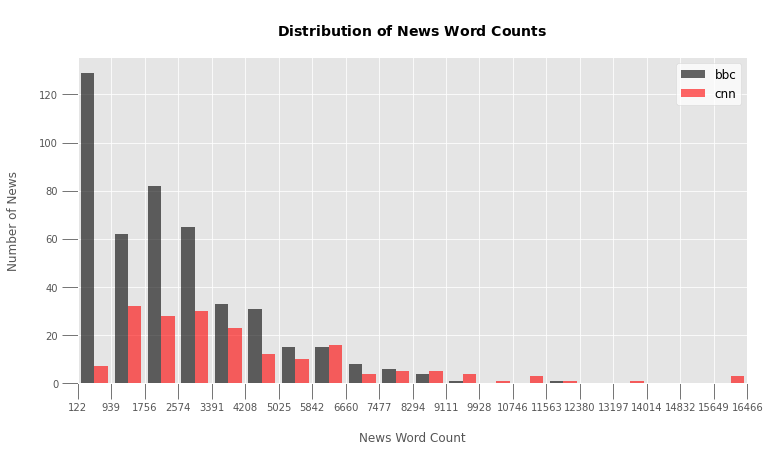

In [ ]:
data_len = [bbc_len, cnn_len]
min_len = min([item for sublist in data_len for item in sublist])
max_len = max([item for sublist in data_len for item in sublist])

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12,6), dpi = 72)
ax1.hist(data_len, bins = 20, color=["black","red"], alpha = 0.6, stacked = False)
ax1.set(xlim=(min_len, max_len), ylabel='Number of News\n', xlabel='\nNews Word Count')
ax1.tick_params(size=16)
ax1.set_xticks(np.linspace(min_len, max_len, 21))

plt.title("\n"+r'$\bf{Distribution\ of\ News\ Word\ Counts}$'+"\n", fontdict=dict(size=14))
plt.legend(["bbc","cnn"], fontsize = 12, facecolor = "white", framealpha = 0.75)
plt.show()

#### Initial word cloud before segregation

In [ ]:
from collections import Counter

cnt_bbc = Counter()
for news in bbc_data_ready:
    for word in news:
        cnt_bbc[word] += 1

cnt_cnn = Counter()
for news in cnn_data_ready:
    for word in news:
        cnt_cnn[word] += 1

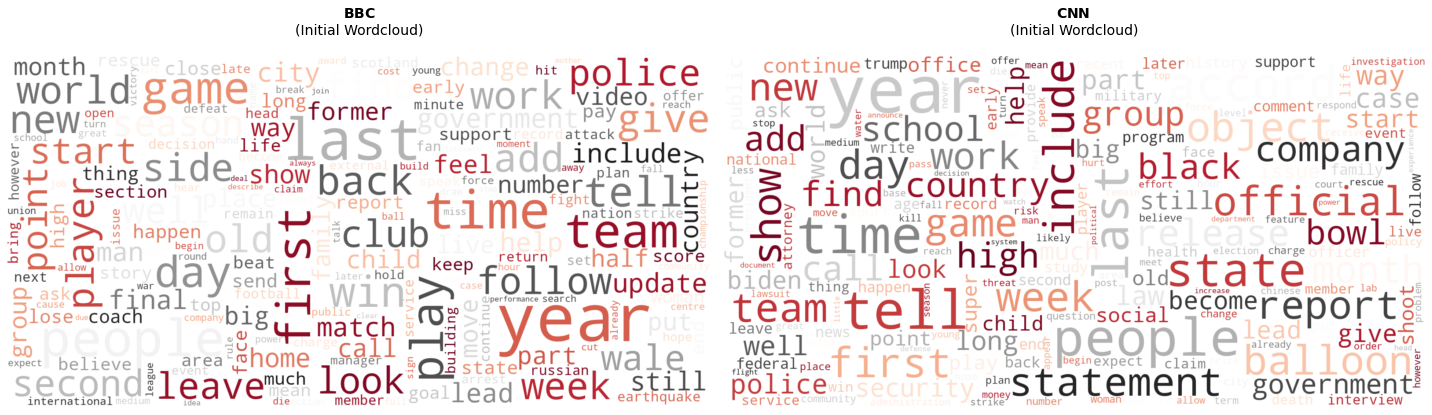

In [ ]:
from wordcloud import WordCloud

channel = ["BBC","CNN"]
cnt = [cnt_bbc, cnt_cnn]

wordcloud = WordCloud(stopwords=stop_words, max_font_size=150, background_color='white', colormap = "RdGy", width=1600, height=800)

fig, axes = plt.subplots(1, 2, figsize=(20,50), dpi = 72, sharex=False, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  wordcloud.generate_from_frequencies(cnt[i])
  plt.gca().imshow(wordcloud, interpolation="bilinear")
  plt.gca().set_title(r"$\bf{"+channel[i]+"}$\n(Initial Wordcloud)\n", fontdict=dict(size=14))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=15, hspace=10)
plt.axis('off')
plt.margins(x=20, y=0)
plt.tight_layout()
plt.show()

#### tf-idf, SVD and tsne-idf
Vectorize each news article into a two-dimentional vector and check the scatterplot.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz_bbc = vectorizer.fit_transform([" ".join(news) for news in bbc_data_ready])
vz_cnn = vectorizer.fit_transform([" ".join(news) for news in cnn_data_ready])

print(vz_bbc.shape)
print(vz_cnn.shape)

(452, 2248)
(185, 1654)


In [ ]:
# Dimension deduction using SVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf_bbc = svd.fit_transform(vz_bbc)
svd_tfidf_cnn = svd.fit_transform(vz_cnn)

print(svd_tfidf_bbc.shape)
print(svd_tfidf_cnn.shape)

(452, 50)
(185, 50)


In [ ]:
# Dimension deduction using TSNE
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_tfidf_bbc = tsne_model.fit_transform(svd_tfidf_bbc)
tsne_tfidf_cnn = tsne_model.fit_transform(svd_tfidf_cnn)
print(tsne_tfidf_bbc.shape)
print(tsne_tfidf_cnn.shape)

tsne_tfidf_bbc_df = pd.DataFrame(tsne_tfidf_bbc)
tsne_tfidf_bbc_df.columns = ['x', 'y']
tsne_tfidf_bbc_df["Content"] = bbc_full["Content"]
tsne_tfidf_bbc_df["Length"] = bbc_len

tsne_tfidf_cnn_df = pd.DataFrame(tsne_tfidf_cnn)
tsne_tfidf_cnn_df.columns = ['x', 'y']
tsne_tfidf_cnn_df["Content"] = cnn_full["Content"]
tsne_tfidf_cnn_df["Length"] = cnn_len

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 452 samples in 0.003s...
[t-SNE] Computed neighbors for 452 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 452 / 452
[t-SNE] Mean sigma: 0.256683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.790840
[t-SNE] KL divergence after 500 iterations: 0.778995
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 185 samples in 0.000s...
[t-SNE] Computed neighbors for 185 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 185 / 185
[t-SNE] Mean sigma: 0.358513
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.758591
[t-SNE] KL divergence after 500 iterations: 0.708633
(452, 2)
(185, 2)


In [ ]:
# Download the result in case it takes too long
tsne_tfidf_bbc_df.to_csv("tsne_tfidf_bbc.csv", index=False)
tsne_tfidf_cnn_df.to_csv("tsne_tfidf_cnn.csv", index=False)
#files.download("tsne_tfidf_bbc.csv")
#files.download("tsne_tfidf_cnn.csv")

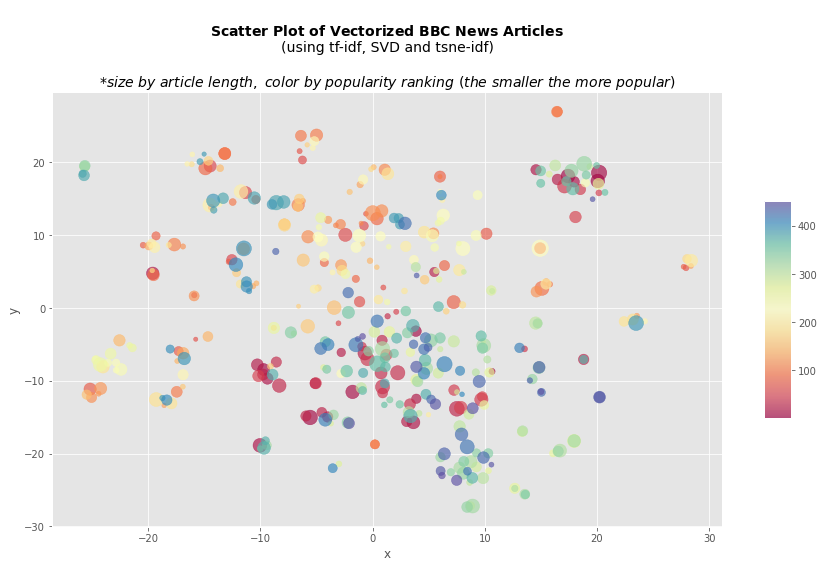

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8), dpi = 72)
ax.margins(0.05) 
sc = ax.scatter(tsne_tfidf_bbc_df.x, tsne_tfidf_bbc_df.y, s = tsne_tfidf_bbc_df.Length**0.6, c = np.arange(1, len(tsne_tfidf_bbc_df)+1), alpha = 0.65, cmap = "Spectral")
fig.colorbar(sc, shrink=0.5, aspect=8, pad = 0.05)
ax.set(ylabel='y', xlabel='x')
plt.title("\n"+r'$\bf{Scatter\ Plot\ of\ Vectorized\ BBC\ News\ Articles}$'+
          "\n(using tf-idf, SVD and tsne-idf)\n\n"+r"$\it{*size\ by\ article\ length,\ color\ by\ popularity\ ranking\ (the\ smaller\ the\ more\ popular)}$", 
          fontdict=dict(size=14))
plt.show()

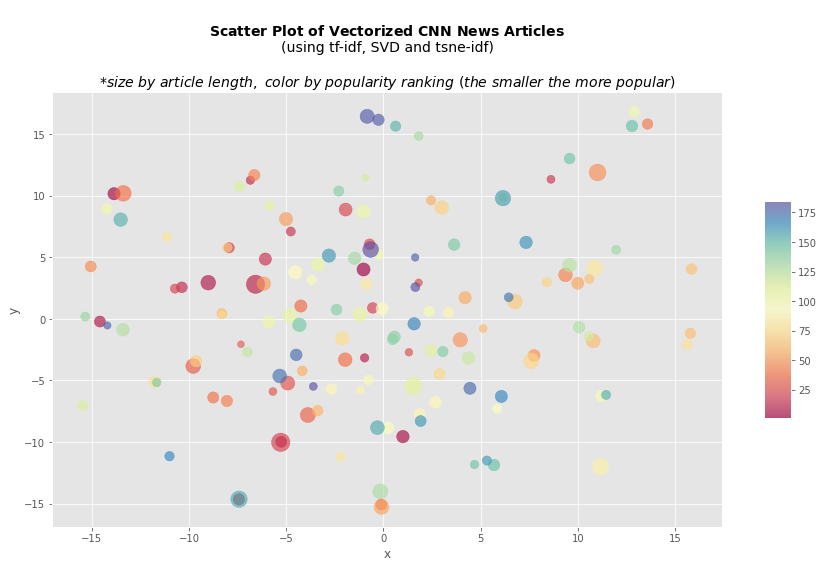

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8), dpi = 72)
ax.margins(0.05) 
sc = ax.scatter(tsne_tfidf_cnn_df.x, tsne_tfidf_cnn_df.y, s = tsne_tfidf_cnn_df.Length**0.6, c = np.arange(1, len(tsne_tfidf_cnn_df)+1), alpha = 0.65, cmap = "Spectral")
fig.colorbar(sc, shrink=0.5, aspect=8, pad = 0.05)
ax.set(ylabel='y', xlabel='x')
plt.title("\n"+r'$\bf{Scatter\ Plot\ of\ Vectorized\ CNN\ News\ Articles}$'+
          "\n(using tf-idf, SVD and tsne-idf)\n\n"+r"$\it{*size\ by\ article\ length,\ color\ by\ popularity\ ranking\ (the\ smaller\ the\ more\ popular)}$", 
          fontdict=dict(size=14))
plt.show()

#### Bokeh: another visualization option

In [ ]:
import bokeh.plotting as bp
import bokeh.models as bmo

from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
from bokeh.io import save, output_file

import matplotlib
import matplotlib.cm as cm

In [ ]:
def color_map_color(value, cmap_name='Spectral', vmin=0, vmax=1):
    norm = plt.Normalize(vmin, vmax)
    #norm = plt.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgb = cmap(norm(abs(value)))[:3]
    color = matplotlib.colors.rgb2hex(rgb)
    return color

tsne_tfidf_bbc_df["Brief"] = tsne_tfidf_bbc_df["Content"].apply(lambda x: str(x)[:300]+"...")
tsne_tfidf_bbc_df["Popularity"] = np.arange(1, len(tsne_tfidf_bbc_df)+1, 1)
tsne_tfidf_bbc_df["Length"] = pd.Series(bbc_len).apply(lambda x: x**0.33)
tsne_tfidf_bbc_df["Color"] = tsne_tfidf_bbc_df["Popularity"].apply(lambda x: color_map_color(x, vmin = 1, vmax = len(tsne_tfidf_bbc_df)+1))

output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="Tf-idf Clustering of BBC News", 
                       tools="pan,wheel_zoom,box_zoom,reset,hover", x_axis_type=None, y_axis_type=None, min_border=1, background_fill_color = "whitesmoke")

plot_tfidf.scatter(x='x', y='y', source=tsne_tfidf_bbc_df, size = "Length", fill_color = "Color", fill_alpha = 0.65, line_alpha = 0)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Popularity Rank": "@Popularity", "Content": "@Brief"}

show(plot_tfidf)

In [ ]:
tsne_tfidf_cnn_df["Brief"] = tsne_tfidf_cnn_df["Content"].apply(lambda x: str(x)[:300]+"...")
tsne_tfidf_cnn_df["Popularity"] = np.arange(1, len(tsne_tfidf_cnn_df)+1, 1)
tsne_tfidf_cnn_df["Length"] = pd.Series(cnn_len).apply(lambda x: x**0.33)
tsne_tfidf_cnn_df["Color"] = tsne_tfidf_cnn_df["Popularity"].apply(lambda x: color_map_color(x, vmin = 1, vmax = len(tsne_tfidf_cnn_df)+1))

output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="Tf-idf Clustering of CNN News", 
                       tools="pan,wheel_zoom,box_zoom,reset,hover", x_axis_type=None, y_axis_type=None, min_border=1, background_fill_color = "whitesmoke")

plot_tfidf.scatter(x='x', y='y', source=tsne_tfidf_cnn_df, size = "Length", fill_color = "Color", fill_alpha = 0.65, line_alpha = 0)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Popularity Rank": "@Popularity", "Content": "@Brief"}

show(plot_tfidf)

### Method I: K-mean

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from tqdm import tqdm, tqdm_notebook

#### BBC

In [ ]:
vz_bbc.shape

(452, 2248)

##### Check cluster number using distortion and silhouette score

In [ ]:
distorsions = []
silhouettes = []
k_max = 16

for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters = k, init = "k-means++", n_init = 1, 
                                   random_state = 42, init_size = 1000, verbose = False, max_iter = 1000)
    kmeans_model.fit(vz_bbc)
    score = silhouette_score(vz_bbc, kmeans_model.labels_)
    silhouettes.append(score)
    distorsions.append(kmeans_model.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

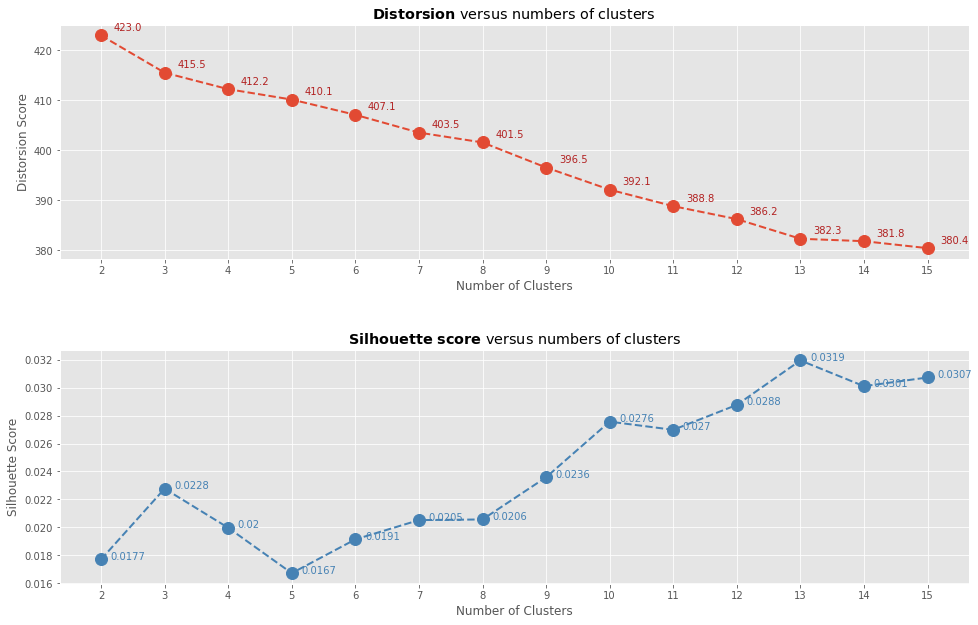

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = False, sharey = False, figsize = (15, 10), dpi = 72)
fig.tight_layout(pad=7)

ax1.plot(range(2, k_max), distorsions, marker='o', linestyle='dashed', linewidth=2, markersize=12)
ax1.set_title(r"$\bf{Distorsion}$"+" versus numbers of clusters")
for i,j in zip(np.arange(2, k_max),distorsions):
    ax1.annotate(str(round(j,1)),xy=(i+0.2,j+1), color = "firebrick")
ax1.set_xticks(np.arange(2, k_max, 1))
ax1.set(ylabel='Distorsion Score', xlabel='Number of Clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), silhouettes, marker='o', linestyle='dashed', linewidth=2, markersize=12, color = "steelblue")
ax2.set_title(r"$\bf{Silhouette\ score}$"+" versus numbers of clusters")
for i,j in zip(np.arange(2, k_max),silhouettes):
    ax2.annotate(str(round(j,4)),xy=(i+0.15,j), color = "steelblue")
ax2.set_xticks(np.arange(2, k_max, 1))
ax2.set(ylabel='Silhouette Score', xlabel='Number of Clusters')
ax2.grid(True)



Choose **13** as the number of cluster since it's with the best silhouette score and relatively good distorsion.

In [ ]:
K = 13

kmeans_model = MiniBatchKMeans(n_clusters = K, init = "k-means++", n_init = 1, 
                               random_state = 42, init_size = 1000, verbose = False, max_iter = 1000)
kmeans = kmeans_model.fit(vz_bbc)
kmeans_clusters = kmeans.predict(vz_bbc)
kmeans_distances = kmeans.transform(vz_bbc)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
vectorizer.fit_transform([" ".join(news) for news in bbc_data_ready])
terms = vectorizer.get_feature_names()

all_keywords = []
for i in range(K):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['Topic {0}'.format(i+1) for i in range(K)], 
                           columns=['Keyword {0}'.format(i+1) for i in range(10)],
                           data=all_keywords)
display(keywords_df.T)

Topic 1          Topic 2   Topic 3    Topic 4     Topic 5  \
Keyword 1    offside             user      brit    russian        year   
Keyword 2       draw        highlight     award    ukraine      people   
Keyword 3       goal           nation    artist  ukrainian       video   
Keyword 4        var   available user     style        jet        work   
Keyword 5       rule              win     album        war         new   
Keyword 6       ring   coverage sound      year        oil       union   
Keyword 7     trophy  nation coverage  category    country        tell   
Keyword 8   reaction     match report       pop    missile  government   
Keyword 9      point        available  ceremony   invasion     service   
Keyword 10    action         coverage       act    fighter       child   

                     Topic 6             Topic 7 Topic 8     Topic 9  \
Keyword 1               user               world  season  earthquake   
Keyword 2     available user        championship  player      rescue   
Keyword 3          available                race    game      rubble   
Keyword 4        follow live  world championship    play      people   
Keyword 5   follow available               women    club    building   
Keyword 6               live                 men    team         aid   
Keyword 7             follow              second    year    disaster   
Keyword 8     live available            downhill     win      syrian   
Keyword 9              indie                gold   final    survivor   
Keyword 10           manager                team  league       quake   

            Topic 10  Topic 11     Topic 12          Topic 13  
Keyword 1     police      wale     scottish          external  
Keyword 2    officer      game     scotland           thistle  
Keyword 3        man      play        video            ranger  
Keyword 4     murder      half         ball          scottish  
Keyword 5     arrest  scotland     continue  require external  
Keyword 6      death       win       scheme      scottish cup  
Keyword 7        die     point         play               cup  
Keyword 8       year      ball        ferry           manager  
Keyword 9   year old    nation  appointment           require  
Keyword 10       old     score       resign           spanish

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_kmeans = tsne_model.fit_transform(svd_tfidf_bbc)

kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['Cluster'] = kmeans_clusters
kmeans_df['Cluster'] = kmeans_df['Cluster'].map(str)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 452 samples in 0.000s...
[t-SNE] Computed neighbors for 452 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 452 / 452
[t-SNE] Mean sigma: 0.256683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.790840
[t-SNE] KL divergence after 500 iterations: 0.778995


In [ ]:
kmeans_df["Brief"] = tsne_tfidf_bbc_df["Content"].apply(lambda x: str(x)[:300]+"...")
kmeans_df["Length"] = pd.Series(bbc_len).apply(lambda x: x**0.33)
kmeans_df["Popularity"] = np.arange(1, len(tsne_tfidf_bbc_df)+1, 1)

reset_output()
output_notebook()
plot_kmean = bp.figure(plot_width=700, plot_height=600, title="K-Mean Clustering of BBC News (K=13)", 
                       tools="pan,wheel_zoom,box_zoom,reset,hover", x_axis_type=None, y_axis_type=None, min_border=1, background_fill_color = "whitesmoke")

palette = d3['Category20'][20] + d3['Category20b'][20] 
color_map = bmo.CategoricalColorMapper(factors=kmeans_df['Cluster'].unique(), palette=palette)

plot_kmean.scatter(x='x', y='y', source=kmeans_df, size = "Length", color={'field': 'Cluster', 'transform': color_map}, legend='Cluster', fill_alpha = 0.5, line_alpha = 0)
hover = plot_kmean.select(dict(type=HoverTool))
hover.tooltips={"Cluster":"@Cluster", "Popularity Rank": "@Popularity", "Content": "@Brief"}

show(plot_kmean)

#### CNN

In [ ]:
vz_cnn.shape

(185, 1654)

##### Check cluster number using distortion and silhouette score

In [ ]:
distorsions = []
silhouettes = []
k_max = 16

for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters = k, init = "k-means++", n_init = 1, 
                                   random_state = 42, init_size = 1000, verbose = False, max_iter = 1000)
    kmeans_model.fit(vz_cnn)
    score = silhouette_score(vz_cnn, kmeans_model.labels_)
    silhouettes.append(score)
    distorsions.append(kmeans_model.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

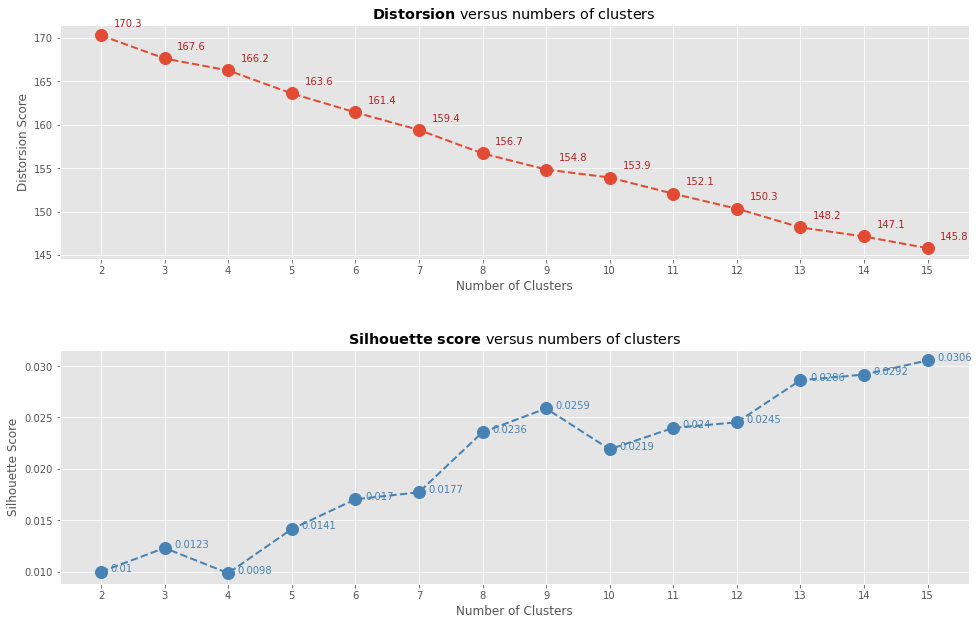

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = False, sharey = False, figsize = (15, 10), dpi = 72)
fig.tight_layout(pad=7)

ax1.plot(range(2, k_max), distorsions, marker='o', linestyle='dashed', linewidth=2, markersize=12)
ax1.set_title(r"$\bf{Distorsion}$"+" versus numbers of clusters")
for i,j in zip(np.arange(2, k_max),distorsions):
    ax1.annotate(str(round(j,1)),xy=(i+0.2,j+1), color = "firebrick")
ax1.set_xticks(np.arange(2, k_max, 1))
ax1.set(ylabel='Distorsion Score', xlabel='Number of Clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), silhouettes, marker='o', linestyle='dashed', linewidth=2, markersize=12, color = "steelblue")
ax2.set_title(r"$\bf{Silhouette\ score}$"+" versus numbers of clusters")
for i,j in zip(np.arange(2, k_max),silhouettes):
    ax2.annotate(str(round(j,4)),xy=(i+0.15,j), color = "steelblue")
ax2.set_xticks(np.arange(2, k_max, 1))
ax2.set(ylabel='Silhouette Score', xlabel='Number of Clusters')
ax2.grid(True)



Choose **9** as the number of cluster since it's with the best silhouette score and relatively good distorsion.

In [ ]:
K = 9

kmeans_model = MiniBatchKMeans(n_clusters = K, init = "k-means++", n_init = 1, 
                               random_state = 42, init_size = 1000, verbose = False, max_iter = 1000)
kmeans = kmeans_model.fit(vz_cnn)
kmeans_clusters = kmeans.predict(vz_cnn)
kmeans_distances = kmeans.transform(vz_cnn)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
vectorizer.fit_transform([" ".join(news) for news in cnn_data_ready])
terms = vectorizer.get_feature_names()

all_keywords = []
for i in range(K):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['Topic {0}'.format(i+1) for i in range(K)], 
                           columns=['Keyword {0}'.format(i+1) for i in range(10)],
                           data=all_keywords)
display(keywords_df.T)

Topic 1   Topic 2    Topic 3     Topic 4       Topic 5  \
Keyword 1     release    player     school      animal       balloon   
Keyword 2       black      team   district     company        object   
Keyword 3      french     movie    student        year       chinese   
Keyword 4   statement  national       tell      people  intelligence   
Keyword 5        year     night     office      energy  surveillance   
Keyword 6        film      time     report  government      official   
Keyword 7        song   receive       case     country         shoot   
Keyword 8       music     fault     letter       study           spy   
Keyword 9    campaign      year     sexual       power      airspace   
Keyword 10      biden      pair  statement      forest      military   

               Topic 6    Topic 7    Topic 8          Topic 9  
Keyword 1         game      price     police            trump  
Keyword 2         bowl   consumer       kill  social security  
Keyword 3        super    average     family         security  
Keyword 4   super bowl       burn        dog           social  
Keyword 5          win    vehicle       year          federal  
Keyword 6        sport  celebrity    officer         document  
Keyword 7         play   customer  statement           border  
Keyword 8         team      datum      death         medicare  
Keyword 9        eagle  inflation       city            biden  
Keyword 10        year        car      group          program

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_kmeans = tsne_model.fit_transform(svd_tfidf_cnn)

kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['Cluster'] = kmeans_clusters
kmeans_df['Cluster'] = kmeans_df['Cluster'].map(str)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 185 samples in 0.000s...
[t-SNE] Computed neighbors for 185 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 185 / 185
[t-SNE] Mean sigma: 0.358513
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.758591
[t-SNE] KL divergence after 500 iterations: 0.708633


In [ ]:
kmeans_df["Brief"] = tsne_tfidf_cnn_df["Content"].apply(lambda x: str(x)[:300]+"...")
kmeans_df["Length"] = pd.Series(cnn_len).apply(lambda x: x**0.33)
kmeans_df["Popularity"] = np.arange(1, len(tsne_tfidf_cnn_df)+1, 1)

reset_output()
output_notebook()
plot_kmean = bp.figure(plot_width=700, plot_height=600, title="K-Mean Clustering of BBC News (K=9)", 
                       tools="pan,wheel_zoom,box_zoom,reset,hover", x_axis_type=None, y_axis_type=None, min_border=1, background_fill_color = "whitesmoke")

palette = d3['Category20'][20] + d3['Category20b'][20] 
color_map = bmo.CategoricalColorMapper(factors=kmeans_df['Cluster'].unique(), palette=palette)

plot_kmean.scatter(x='x', y='y', source=kmeans_df, size = "Length", color={'field': 'Cluster', 'transform': color_map}, legend='Cluster', fill_alpha = 0.5, line_alpha = 0)
hover = plot_kmean.select(dict(type=HoverTool))
hover.tooltips={"Cluster":"@Cluster", "Popularity": "@Popularity", "Content": "@Brief"}

show(plot_kmean)

### Method II: LDA

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from tqdm import tqdm
tqdm.pandas()

#### BBC

##### Create id2word and corpus

In [ ]:
id2word_bbc = corpora.Dictionary(bbc_data_ready)
corpus_bbc = [id2word_bbc.doc2bow(page) for page in bbc_data_ready]

##### Build LDA and check the numbers of topics

In [ ]:
# Function to create LDA models
def create_lda_model(corpus, id2word, num_topics, random_state = 42, update_every = 1, chunksize = 10, 
              passes = 10, alpha = "symmetric", iterations = 100, per_word_topics = True):
  return gensim.models.ldamodel.LdaModel(corpus = corpus,
                                         id2word = id2word,
                                         num_topics = num_topics, 
                                         random_state = random_state,
                                         update_every = update_every,
                                         chunksize = chunksize,
                                         passes = passes,
                                         alpha = alpha,
                                         iterations = iterations,
                                         per_word_topics = per_word_topics)

In [ ]:
# Function to get coherence score
def get_coherence(model, tokens, data_full, id2word):
  bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  text = pd.Series(tokens).progress_map(lambda tokens: bigram_mod[tokens])
  
  coherence = CoherenceModel(model=model,
                             texts = text.values,
                             dictionary=id2word, coherence='c_v')
  return coherence.get_coherence()

In [ ]:
topic_num = np.arange(2, 16, 1)
coherence = []

for t in topic_num:
  lda_model = create_lda_model(corpus = corpus_bbc, id2word = id2word_bbc, num_topics = t)
  c = get_coherence(model = lda_model, tokens = bbc_data_ready, data_full = bbc_full, id2word = id2word_bbc)
  coherence.append(c)

100%|██████████| 452/452 [00:00<00:00, 2381.39it/s]


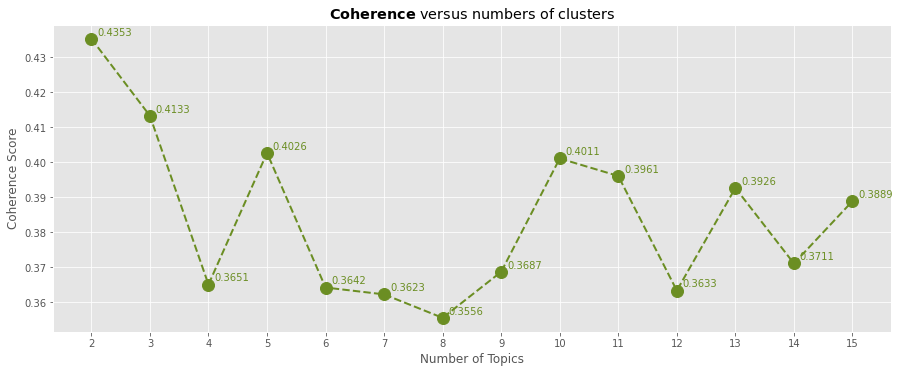

In [ ]:
fig, ax = plt.subplots(figsize = (14, 6.5), dpi = 72)
fig.tight_layout(pad=7)

ax.plot(range(2, 16), coherence, marker='o', linestyle='dashed', linewidth=2, markersize=12, color = "olivedrab")
ax.set_title(r"$\bf{Coherence}$"+" versus numbers of clusters")
for i,j in zip(topic_num, coherence):
    ax.annotate(str(round(j,4)),xy=(i+0.1,j+0.001), color = "olivedrab")
ax.set_xticks(topic_num)
ax.set(ylabel='Coherence Score', xlabel='Number of Topics')
ax.grid(True)

Choose **10** as the number of topics. Even though 2, 3 and 5 have higher coherence, relatively small numbers of topics might potentially miss some information.

In [ ]:
T = 10

##### LDA model with optimal number of topics

In [ ]:
lda_model = create_lda_model(corpus = corpus_bbc, id2word = id2word_bbc, num_topics = T)
for i in range(T):
    print("\nTopic "+str(i+1)+":")
    display(lda_model.show_topic(i))


Topic 1:


[('year', 0.017878558),
 ('day', 0.014600596),
 ('story', 0.013807763),
 ('people', 0.012755858),
 ('team', 0.011364642),
 ('tell', 0.009634218),
 ('feel', 0.009542935),
 ('hear', 0.00946466),
 ('help', 0.009240039),
 ('life', 0.0088448115)]


Topic 2:


[('health', 0.022814957),
 ('strike', 0.015279979),
 ('offer', 0.013689585),
 ('give', 0.009339476),
 ('leader', 0.008941221),
 ('hold', 0.008577569),
 ('mccall', 0.0085007325),
 ('impact', 0.008459808),
 ('water', 0.0082762325),
 ('move', 0.00821431)]


Topic 3:


[('service', 0.03399535),
 ('school', 0.028077109),
 ('road', 0.026455415),
 ('teacher', 0.014287157),
 ('authority', 0.013725295),
 ('site', 0.012567004),
 ('event', 0.012357335),
 ('emergency', 0.009877478),
 ('damage', 0.00974472),
 ('turbine', 0.009522777)]


Topic 4:


[('police', 0.026275635),
 ('year', 0.018041752),
 ('man', 0.017560957),
 ('later', 0.012766257),
 ('scotland', 0.012754638),
 ('send', 0.012375063),
 ('arrest', 0.012329746),
 ('die', 0.011902282),
 ('work', 0.011270436),
 ('week', 0.010535178)]


Topic 5:


[('last', 0.024640858),
 ('play', 0.023306243),
 ('win', 0.016630813),
 ('game', 0.016480392),
 ('first', 0.014857685),
 ('year', 0.013398263),
 ('time', 0.01339764),
 ('player', 0.012958826),
 ('club', 0.012868371),
 ('match', 0.01129893)]


Topic 6:


[('issue', 0.014662517),
 ('incident', 0.012777415),
 ('tell', 0.011013028),
 ('candidate', 0.009530645),
 ('party', 0.00935779),
 ('short', 0.009132912),
 ('apprentice', 0.0073917415),
 ('glasgow', 0.007366852),
 ('claim', 0.007154712),
 ('public', 0.006607376)]


Topic 7:


[('find', 0.023554053),
 ('child', 0.020888256),
 ('people', 0.017870309),
 ('area', 0.015837545),
 ('woman', 0.012870779),
 ('rescue', 0.012231806),
 ('kill', 0.0113097485),
 ('building', 0.010822679),
 ('earthquake', 0.010802693),
 ('investigation', 0.010770864)]


Topic 8:


[('pay', 0.015356933),
 ('union', 0.014462711),
 ('year', 0.0142109655),
 ('government', 0.014020875),
 ('plan', 0.01315839),
 ('new', 0.012980776),
 ('process', 0.012931177),
 ('council', 0.012233968),
 ('tax', 0.012117473),
 ('officer', 0.011663152)]


Topic 9:


[('passenger', 0.014861577),
 ('education', 0.014642611),
 ('ferry', 0.014392296),
 ('senior', 0.014339054),
 ('childcare', 0.012081591),
 ('particularly', 0.010133332),
 ('crew', 0.009790579),
 ('policy', 0.009421903),
 ('treat', 0.009146975),
 ('migrant', 0.008106148)]


Topic 10:


[('wale', 0.018025983),
 ('award', 0.014985392),
 ('crash', 0.0144880125),
 ('open', 0.0132245105),
 ('irish', 0.010855355),
 ('back', 0.010403358),
 ('touch', 0.010332075),
 ('female', 0.009777439),
 ('half', 0.009063204),
 ('artist', 0.008286925)]

Topic probability for each page (presenting first 10 pages for example)

In [ ]:
for i, row_list in enumerate(lda_model[corpus_bbc][:10]):
    print (row_list[0])

[(0, 0.3100319), (1, 0.019768834), (3, 0.10339743), (5, 0.03257324), (6, 0.3793565), (7, 0.061749622), (8, 0.04564317), (9, 0.04238507)]
[(0, 0.1555938), (2, 0.5010267), (3, 0.06205906), (5, 0.18224834), (6, 0.051125277), (7, 0.019089976), (9, 0.027294226)]
[(0, 0.14668046), (3, 0.8003063), (4, 0.012727922), (6, 0.02076238), (9, 0.012280873)]
[(0, 0.53529924), (1, 0.107961066), (5, 0.07239418), (6, 0.17949173), (9, 0.09381772)]
[(0, 0.10895382), (3, 0.6077971), (5, 0.016995253), (6, 0.045655116), (7, 0.03288705), (8, 0.12912832), (9, 0.057020713)]
[(0, 0.16621928), (1, 0.03706043), (3, 0.06098786), (4, 0.011861325), (7, 0.7088314)]
[(0, 0.5309207), (3, 0.11782865), (8, 0.31791425)]
[(0, 0.32942647), (1, 0.040289283), (2, 0.051703975), (3, 0.06587265), (4, 0.013058308), (6, 0.26080588), (9, 0.21410388)]
[(0, 0.3246456), (1, 0.03516081), (2, 0.042289805), (3, 0.091735624), (4, 0.37505552), (5, 0.0635893), (8, 0.029578732), (9, 0.028074952)]
[(0, 0.28001636), (3, 0.07392674), (4, 0.113339

##### Word clouds for topics

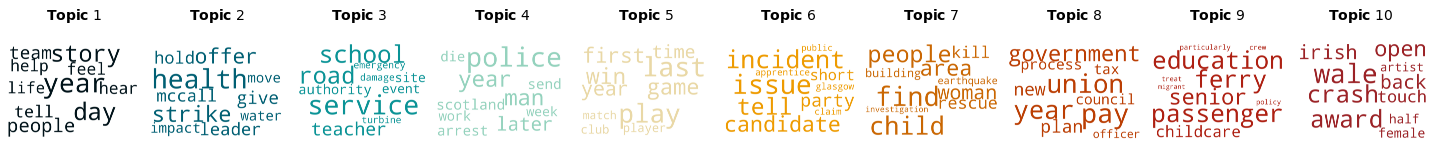

In [ ]:
colors = ["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6",
       "#EE9B00", "#CA6702", "#BB3E03", "#AE2012", "#9B2226"]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, T, figsize=(20, 36), dpi = 72, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title(r'$\bf{Topic}$ ' + str(i+1)+"\n", fontdict=dict(size=14))
    plt.gca().axis('off')

plt.axis('off')
plt.tight_layout(pad = 1)
plt.show()

##### Insights of terms of each topic

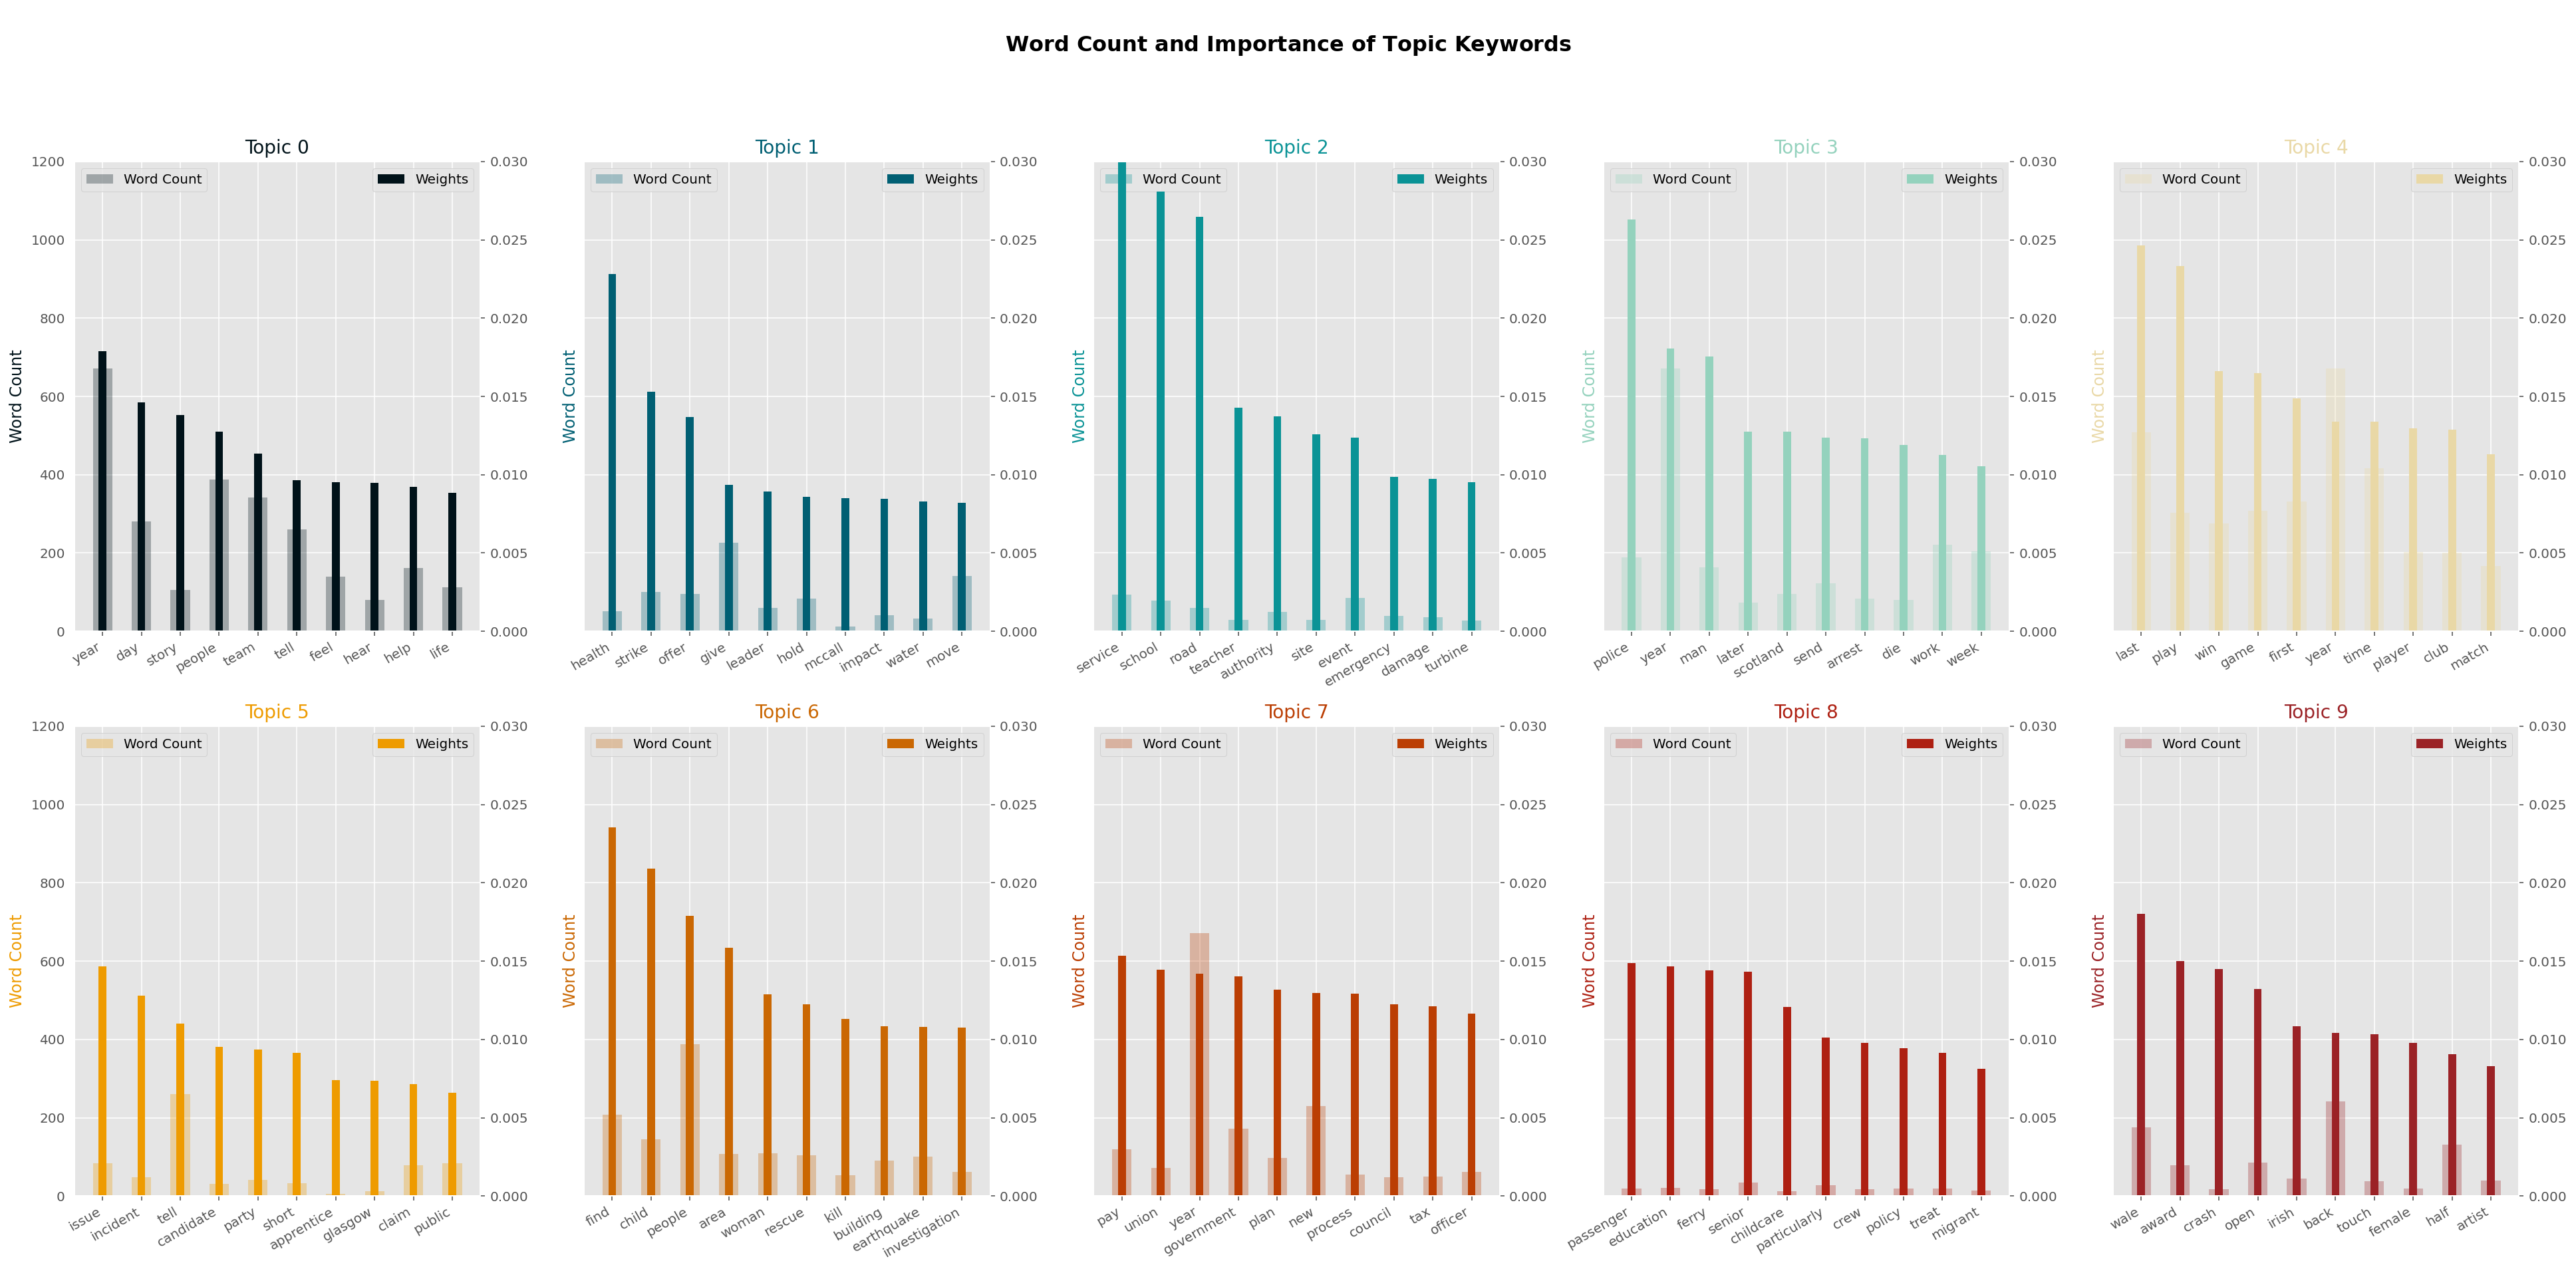

In [ ]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in bbc_data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(27, 12), sharey=True, dpi=144)
#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=colors[i], 
           width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=colors[i], 
                width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=colors[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1200)
    ax.set_title('Topic ' + str(i), color=colors[i], fontsize=14)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    ax_twin.grid(None)

fig.tight_layout(w_pad=1)    
fig.suptitle('\n'+r'$\bf{Word\ Count\ and\ Importance\ of\ Topic\ Keywords}$', fontsize=16, y=1.1)    
plt.show()

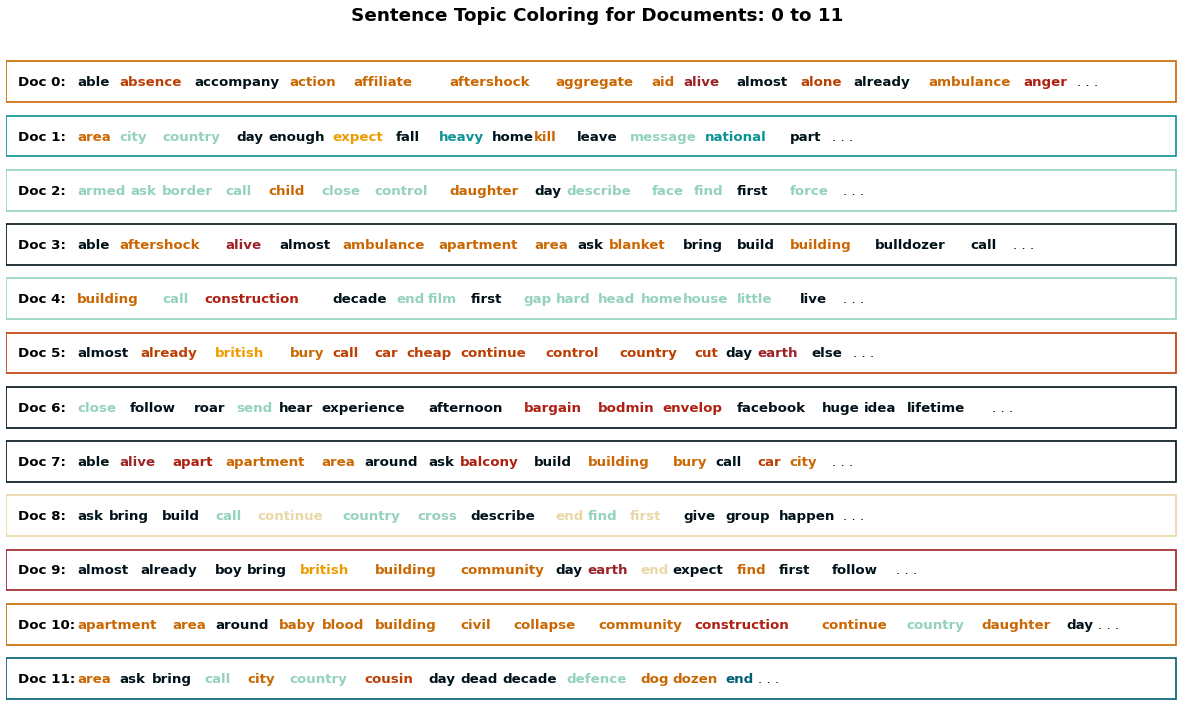

In [ ]:
from matplotlib.patches import Rectangle


def sentences_chart(lda_model, corpus, start = 0, end = 13):
    corp = corpus[start:end]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=60)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=colors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=colors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model=lda_model, corpus=corpus_bbc)

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus_bbc, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < T]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

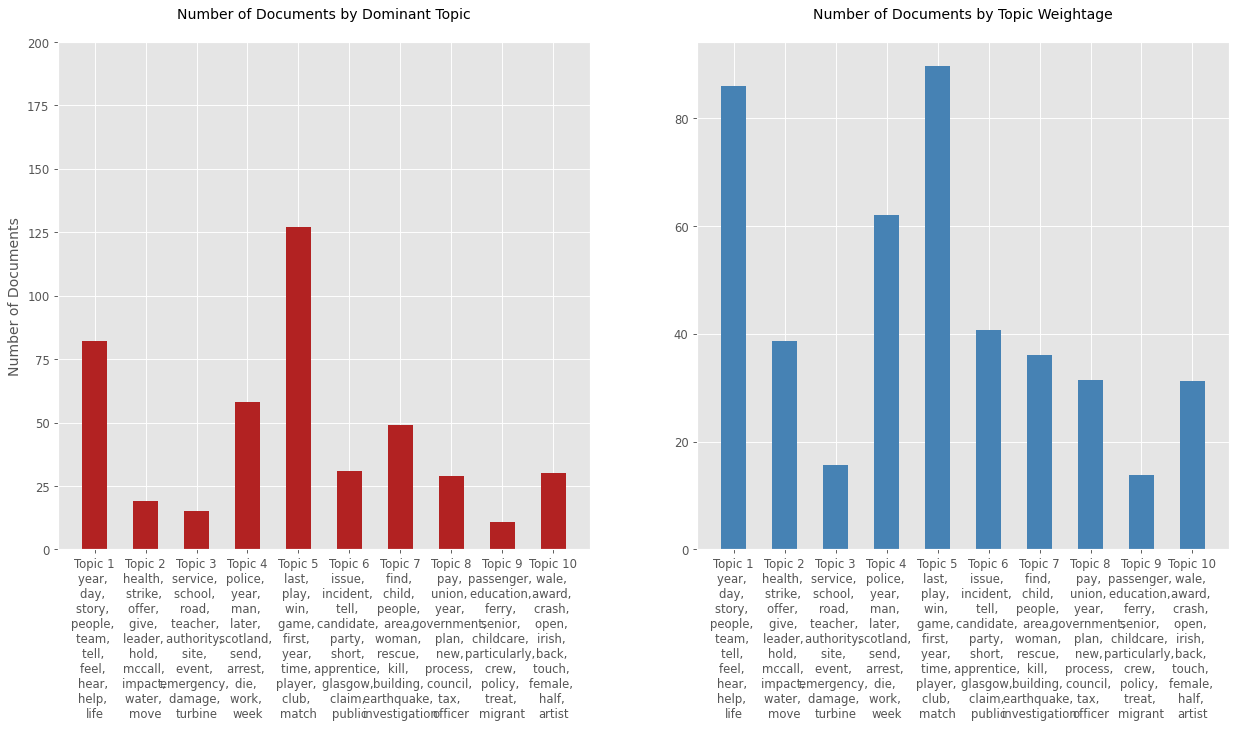

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), dpi=84)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, 
                               pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].\
                               values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic\n', fontdict=dict(size=12))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage\n', fontdict=dict(size=12))

plt.show()

##### Visualization: Bokeh

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus_bbc]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = T
#mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors = np.array(colors)
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), min_width=900, min_height=300)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], alpha = 0.5, size=8)
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 288 samples in 0.001s...
[t-SNE] Computed neighbors for 288 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 288 / 288
[t-SNE] Mean sigma: 0.165583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.242237
[t-SNE] KL divergence after 1000 iterations: 0.312602


##### Visualization: pyLDAvis

In [ ]:
 !pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))
display(HTML("<style>.output_area { max-width:95% !important; }</style>"))
display(HTML("<style>.input_area { max-width:95% !important; }</style>"))

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus_bbc, dictionary=lda_model.id2word)

In [ ]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.238795 -0.047255       1        1  18.050153
4     -0.138056  0.162667       2        1  16.676746
3     -0.168448 -0.110418       3        1  12.756589
1      0.024581  0.139102       4        1   9.691660
7      0.039063 -0.192457       5        1   9.494066
5      0.107774  0.051900       6        1   9.465716
6      0.067535 -0.178238       7        1   9.412877
9     -0.000333  0.152661       8        1   8.224982
2      0.163239  0.000290       9        1   3.556669
8      0.143440  0.021747      10        1   2.670543, topic_info=          Term        Freq       Total Category  logprob  loglift
919       play  281.000000  281.000000  Default  30.0000  30.0000
499     police  243.000000  243.000000  Default  29.0000  29.0000
1951    health  160.000000  160.000000  Default  28.0000  28.0000
186     people  310.000000  310.000000  Default  27.0000  27.0000
377    service  128.000000  128.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
8275  drogheda   10.278678   11.641980  Topic10  -5.2354   3.4983
8895      mull   10.338964   12.506884  Topic10  -5.2295   3.4325
614      human   11.679795   16.016971  Topic10  -5.1076   3.3071
8273    cruise    8.671126   10.162749  Topic10  -5.4054   3.4642
711        age    8.992445   36.366412  Topic10  -5.3690   2.2256

[471 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
999       3  0.989621  accord
1000      1  0.978401     act
3         6  0.582479  action
3         7  0.325105  action
3        10  0.081276  action
...     ...       ...     ...
286       5  0.140544    year
286       7  0.051628    year
286       8  0.002868    year
1675      4  0.977718     yet
550       1  0.994551   young

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 8, 6, 7, 10, 3, 9])

#### CNN

##### Create id2word and corpus

In [ ]:
id2word_cnn = corpora.Dictionary(cnn_data_ready)
corpus_cnn = [id2word_cnn.doc2bow(page) for page in cnn_data_ready]

##### Build LDA and check the numbers of topics

In [ ]:
warnings.filterwarnings("ignore")

topic_num = np.arange(2, 16, 1)
coherence = []

for t in topic_num:
  lda_model = create_lda_model(corpus = corpus_cnn, id2word = id2word_cnn, num_topics = t)
  c = get_coherence(model = lda_model, tokens = cnn_data_ready, data_full = cnn_full, id2word = id2word_cnn)
  coherence.append(c)

100%|██████████| 185/185 [00:00<00:00, 1371.57it/s]


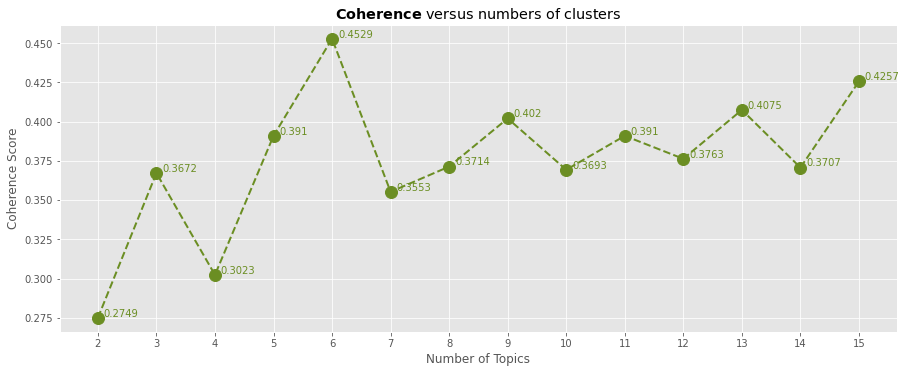

In [ ]:
fig, ax = plt.subplots(figsize = (14, 6.5), dpi = 72)
fig.tight_layout(pad=7)

ax.plot(range(2, 16), coherence, marker='o', linestyle='dashed', linewidth=2, markersize=12, color = "olivedrab")
ax.set_title(r"$\bf{Coherence}$"+" versus numbers of clusters")
for i,j in zip(topic_num, coherence):
    ax.annotate(str(round(j,4)),xy=(i+0.1,j+0.001), color = "olivedrab")
ax.set_xticks(topic_num)
ax.set(ylabel='Coherence Score', xlabel='Number of Topics')
ax.grid(True)

Choose **6** as the number of topics since it's significantly better than others.

In [ ]:
T = 6

##### LDA model with optimal number of topics

In [ ]:
warnings.filterwarnings("ignore")

lda_model = create_lda_model(corpus = corpus_cnn, id2word = id2word_cnn, num_topics = T)
for i in range(T):
    print("\nTopic "+str(i+1)+":")
    display(lda_model.show_topic(i))


Topic 1:


[('year', 0.011237484),
 ('document', 0.008744895),
 ('tell', 0.008220115),
 ('school', 0.008186767),
 ('state', 0.0081044),
 ('office', 0.008104147),
 ('comment', 0.0080779195),
 ('law', 0.0077998573),
 ('former', 0.0076664183),
 ('policy', 0.007598409)]


Topic 2:


[('officer', 0.04059809),
 ('police', 0.029601172),
 ('department', 0.014680695),
 ('apple', 0.013094178),
 ('recruit', 0.010080826),
 ('standard', 0.008873831),
 ('enforcement', 0.008777158),
 ('man', 0.00812104),
 ('training', 0.0078114783),
 ('fentanyl', 0.00778556)]


Topic 3:


[('big', 0.017721152),
 ('company', 0.013925356),
 ('grow', 0.013848276),
 ('iphone', 0.010757805),
 ('bonus', 0.01069341),
 ('manufacture', 0.009338004),
 ('attract', 0.009141941),
 ('manufacturing', 0.008916939),
 ('production', 0.0077193924),
 ('factory', 0.0072077536)]


Topic 4:


[('twitter', 0.012505946),
 ('accord', 0.007447161),
 ('year', 0.007127381),
 ('service', 0.00666782),
 ('child', 0.006643519),
 ('antisemitism', 0.0065370137),
 ('hate', 0.0064735524),
 ('people', 0.0063336217),
 ('include', 0.0058841254),
 ('important', 0.005851599)]


Topic 5:


[('object', 0.01711248),
 ('balloon', 0.013910567),
 ('official', 0.0117623275),
 ('last', 0.011728908),
 ('biden', 0.0079550585),
 ('shoot', 0.007154496),
 ('time', 0.006587029),
 ('week', 0.006461525),
 ('country', 0.0063909194),
 ('trump', 0.0063082874)]


Topic 6:


[('year', 0.016166106),
 ('game', 0.012389375),
 ('bowl', 0.01197686),
 ('first', 0.009839499),
 ('time', 0.009404579),
 ('team', 0.00924952),
 ('win', 0.008535546),
 ('super', 0.008504292),
 ('player', 0.0077101258),
 ('play', 0.007407844)]

Topic probability for each page (presenting first 10 pages for example)

In [ ]:
for i, row_list in enumerate(lda_model[corpus_cnn][:10]):
    print (row_list[0])

[(0, 0.2506465), (1, 0.60626304), (3, 0.03639382), (5, 0.10575483)]
[(0, 0.07618551), (3, 0.71623975), (4, 0.18346821), (5, 0.013882047)]
[(0, 0.22193314), (1, 0.09295112), (2, 0.32902715), (3, 0.017996231), (4, 0.28470212), (5, 0.0533902)]
[(0, 0.8217314), (2, 0.014694374), (3, 0.03532244), (4, 0.12660097)]
[(2, 0.40631148), (3, 0.08385655), (4, 0.3780504), (5, 0.13036443)]
[(0, 0.092662245), (1, 0.017392622), (3, 0.72667325), (4, 0.06363509), (5, 0.098850355)]
[(0, 0.8701701), (1, 0.023508603), (3, 0.019985888), (5, 0.08346314)]
[(3, 0.06735277), (4, 0.113861695), (5, 0.8123175)]
[(0, 0.1952047), (1, 0.015560268), (2, 0.0115303015), (3, 0.62326515), (5, 0.15429193)]
[(0, 0.123068124), (1, 0.337561), (2, 0.062353816), (3, 0.060081087), (4, 0.3366336), (5, 0.08030236)]


##### Word clouds for topics

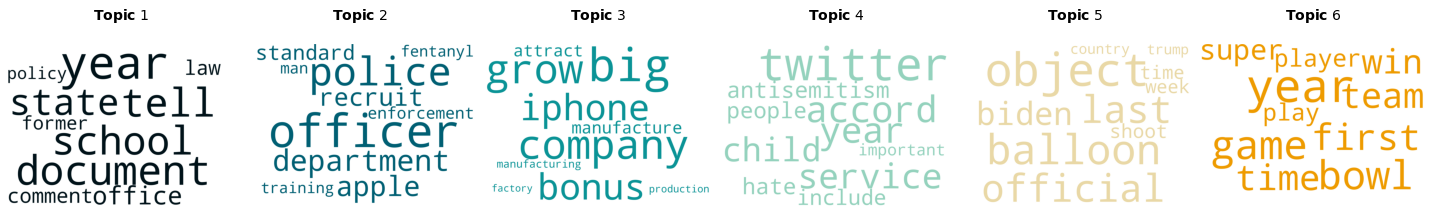

In [ ]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, T, figsize=(20, 36), dpi = 72, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title(r'$\bf{Topic}$ ' + str(i+1)+"\n", fontdict=dict(size=14))
    plt.gca().axis('off')

plt.axis('off')
plt.tight_layout(pad = 1)
plt.show()

##### Insights of terms of each topic

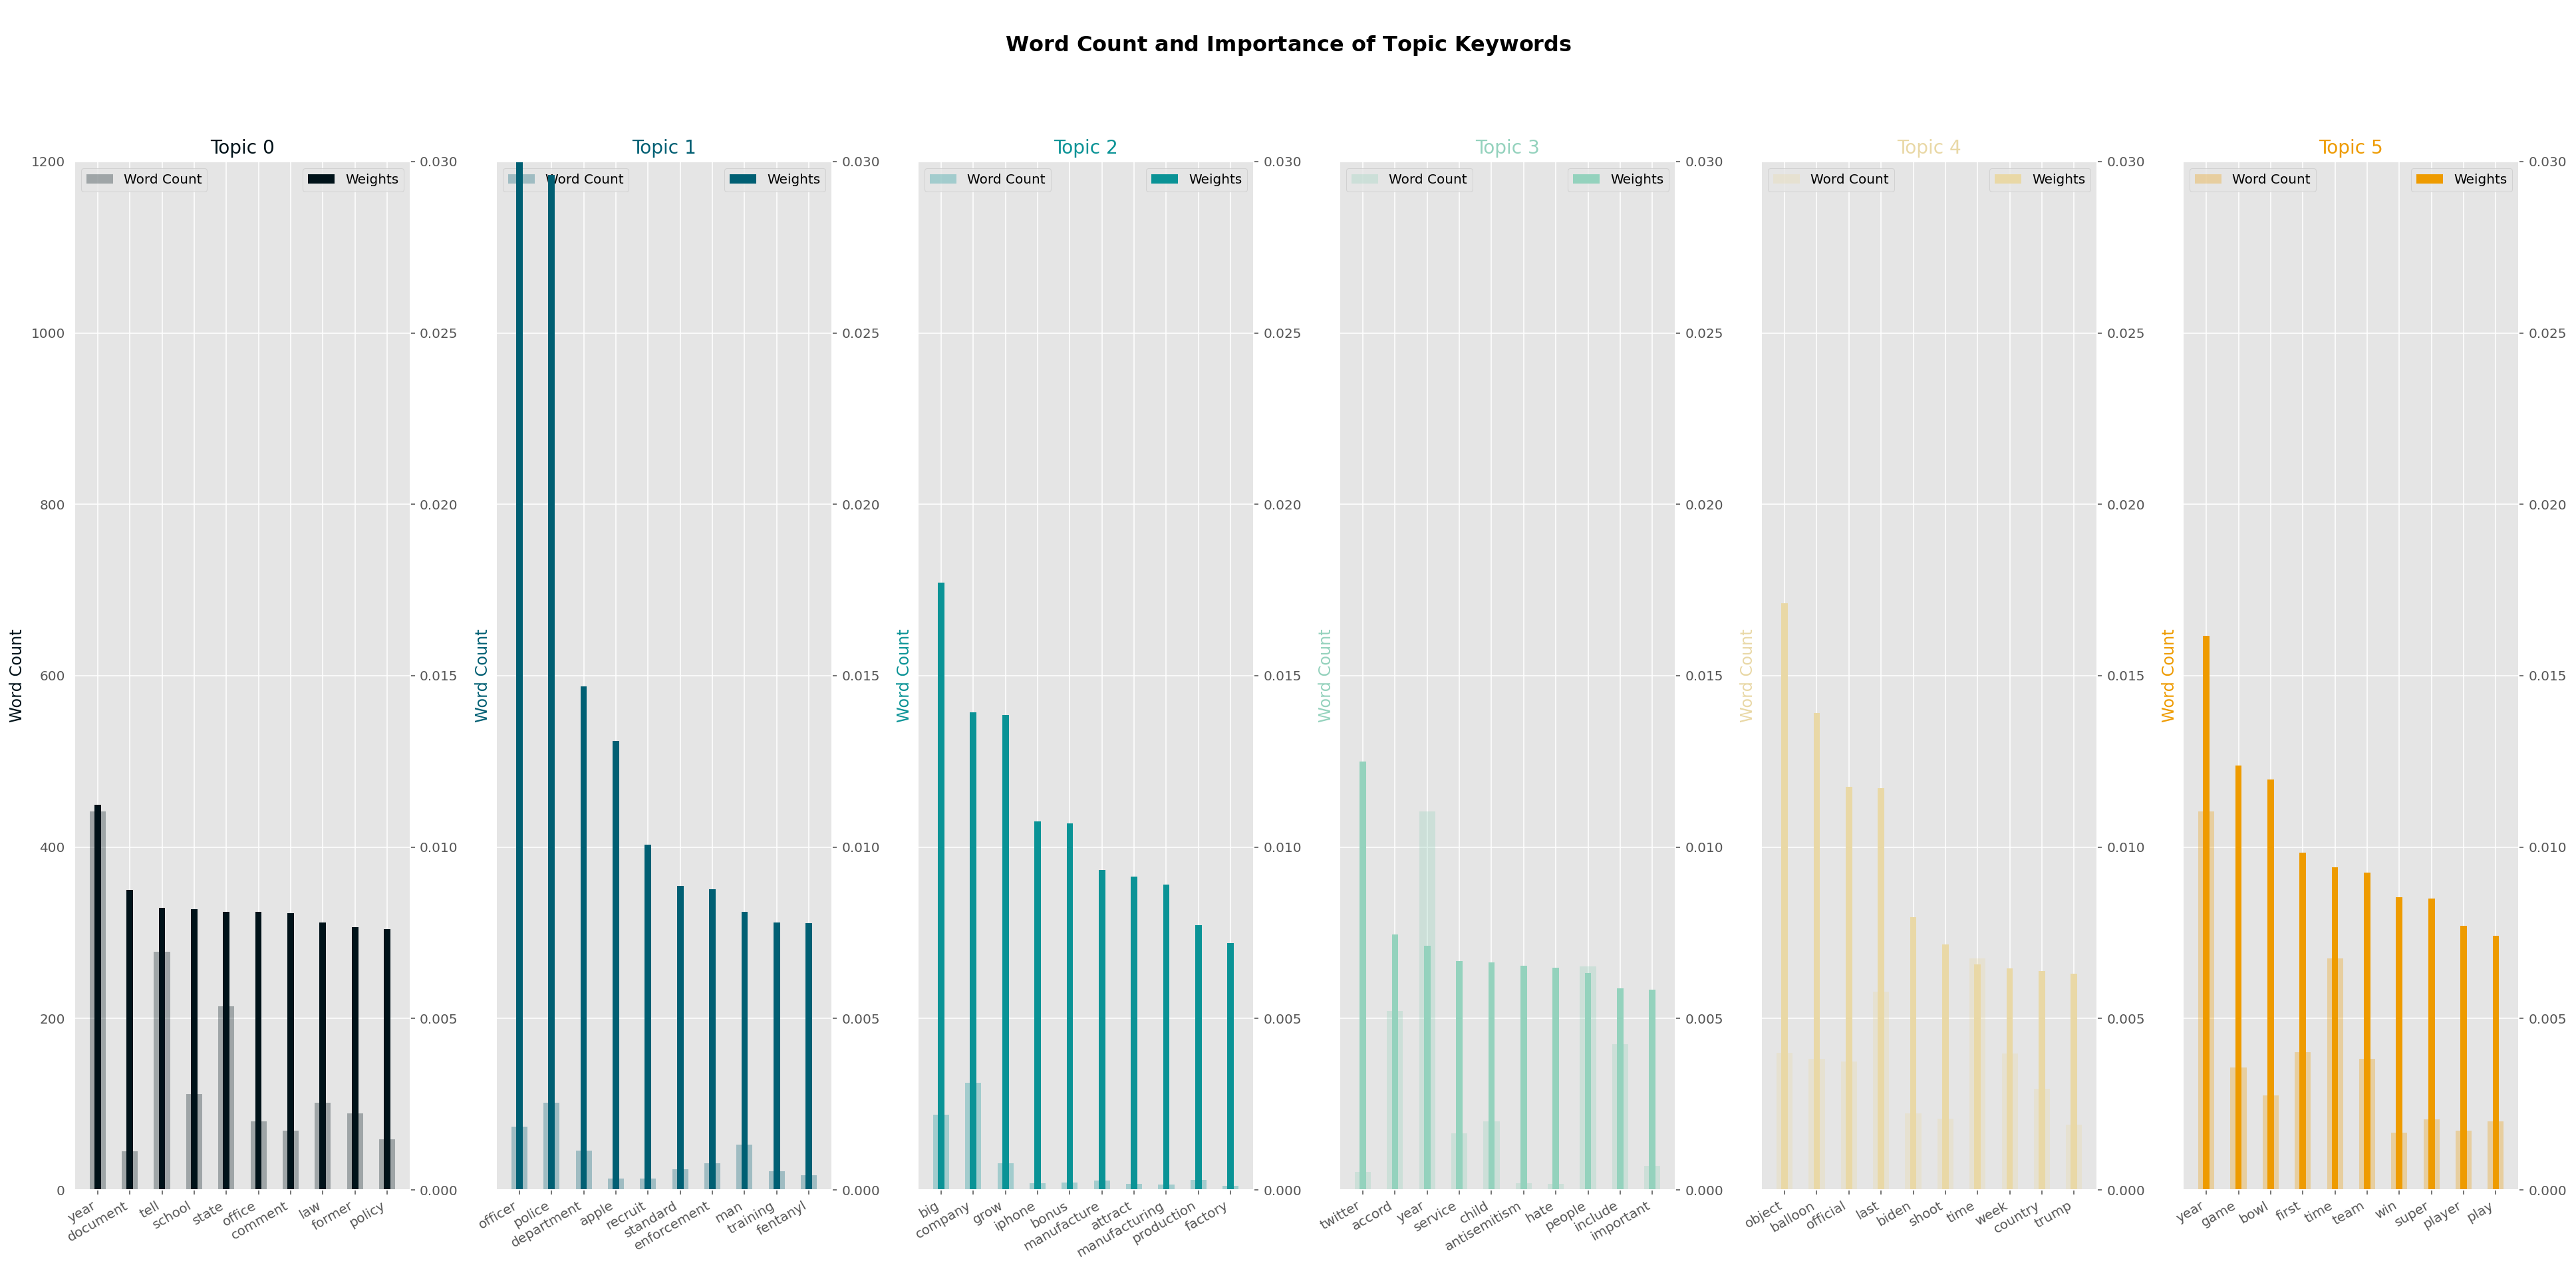

In [ ]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in cnn_data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 6, figsize=(27, 12), sharey=True, dpi=144)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=colors[i], 
           width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=colors[i], 
                width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=colors[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1200)
    ax.set_title('Topic ' + str(i), color=colors[i], fontsize=14)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    ax_twin.grid(None)

fig.tight_layout(w_pad=1)    
fig.suptitle('\n'+r'$\bf{Word\ Count\ and\ Importance\ of\ Topic\ Keywords}$', fontsize=16, y=1.1)    
plt.show()

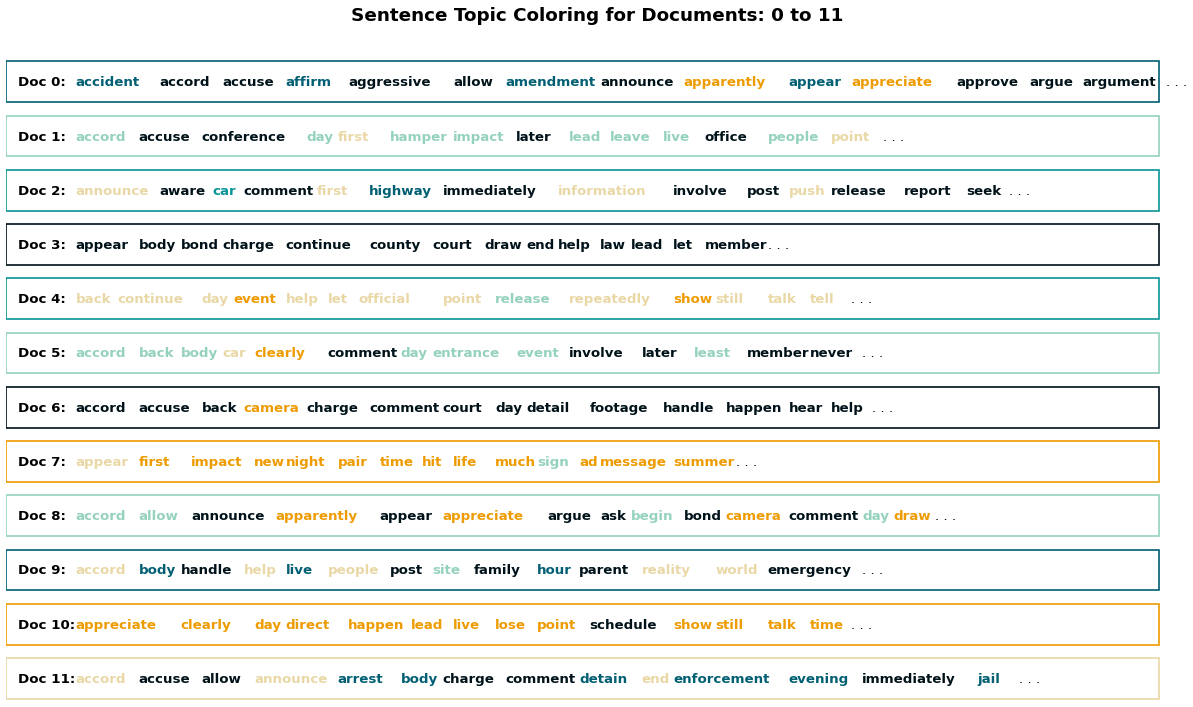

In [ ]:
sentences_chart(lda_model=lda_model, corpus=corpus_cnn)

In [ ]:
# Sentence Coloring of N Sentences
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus_cnn, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < T]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

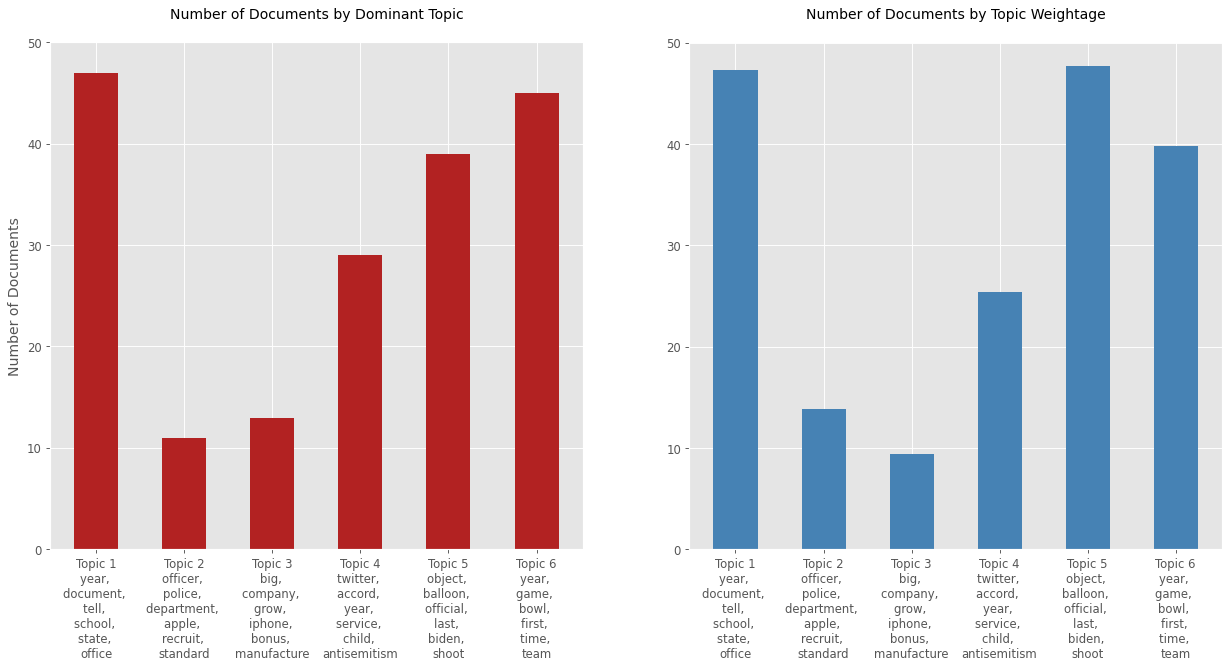

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), dpi=84)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, 
                               pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].\
                               values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic\n', fontdict=dict(size=12))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 50)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage\n', fontdict=dict(size=12))

plt.show()

##### Visualization: Bokeh

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus_cnn]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = T
#mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors = np.array(colors)
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), min_width=900, min_height=300)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], alpha = 0.5, size=8)
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.000s...
[t-SNE] Computed neighbors for 167 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.232808
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.822586
[t-SNE] KL divergence after 700 iterations: 0.235189


##### Visualization: pyLDAvis

In [ ]:
 #!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))
display(HTML("<style>.output_area { max-width:95% !important; }</style>"))
display(HTML("<style>.input_area { max-width:95% !important; }</style>"))

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus_cnn, dictionary=lda_model.id2word)

In [ ]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.241626  0.151097       1        1  28.190952
0      0.127956 -0.260119       2        1  25.756974
5      0.019047  0.010018       3        1  18.696499
3     -0.034310  0.036615       4        1  15.202904
1     -0.221895 -0.068198       5        1   6.834777
2     -0.132424  0.130587       6        1   5.317894, topic_info=            Term        Freq       Total Category  logprob  loglift
125      officer  143.000000  143.000000  Default  30.0000  30.0000
3688      object  249.000000  249.000000  Default  29.0000  29.0000
135       police  108.000000  108.000000  Default  28.0000  28.0000
1856     balloon  202.000000  202.000000  Default  27.0000  27.0000
1093         big   96.000000   96.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
777     strategy   15.773900   30.088695   Topic6  -5.1576   2.2883
727   investment   13.197900   20.464150   Topic6  -5.3359   2.4955
674         year   19.210295  457.363469   Topic6  -4.9605  -0.2359
766         rise   14.171371   63.125477   Topic6  -5.2647   1.4402
120          new   13.234158  100.524057   Topic6  -5.3331   0.9065

[316 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1061      4  0.963517  ability
1         1  0.297260   accord
1         2  0.415290   accord
1         4  0.253545   accord
1         5  0.030600   accord
...     ...       ...      ...
674       1  0.168356     year
674       2  0.325780     year
674       3  0.341085     year
674       4  0.122441     year
674       6  0.041542     year

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 4, 2, 3])